In [1]:
import matplotlib.pyplot as plt
import imageio.v2 as iio
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import directed_hausdorff
from sklearn import decomposition
from skimage import registration,img_as_bool
from skimage.transform import warp, downscale_local_mean, EuclideanTransform, rotate
from skimage import img_as_float32
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, marching_cubes
import mrcfile
import math
import napari
from skimage.metrics import hausdorff_distance, hausdorff_pair, mean_squared_error
from skimage.filters import threshold_otsu, sobel
from skimage.draw import line_nd, ellipse, polygon
import time
from tqdm import tqdm
from itertools import product
import multiprocessing
import concurrent.futures

from src import asymmetry_3D
from src import prepare_center_pca
from src.asymmetry_3D import *
from src.utils import *
from src.prepare_center_pca_3D import *

%load_ext autoreload
%autoreload 2
V = napari.Viewer(ndisplay = 3)

1. Load data

A note on python arrays: they start indexing at 0 i.e., the first element of an array is Array[0], unlike matlab where this would be Array(1)\
Volume images are arrays with 3 axes. In python the axes order is Array[z, y, x], see the schematic below\
\
Important! At the moment, this code assumes that: 
- the volumes have been aligned to center of mass and first axis of inertia up, i.e., along axis 0 of the numpy indexing.
- the images have been binarized previously. All background pixels are 0.

The computation takes a few minutes for volumes ~ 100 x 150 x 100 voxels, increase this at your own risk!\
*TO DO*\
Include the rotation and alignment in 3D, in python

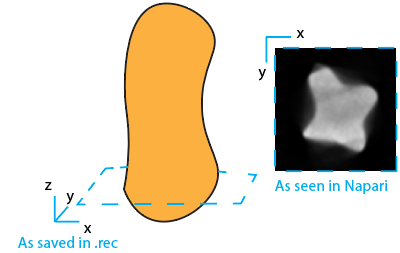

In [2]:
filename = 'test/chiral_TwistedSC.tif' # Let's assume this has been rotated in matlab before
Q = read_data(filename)

print(f'volume size: {Q.shape}')
print(f'number of voxels: {Q.shape[0]*Q.shape[1]*Q.shape[2]}')
print(f'number of surface voxels: {np.count_nonzero(get_edges(Q))}')

volume size: (84, 62, 62)
number of voxels: 322896
number of surface voxels: 21184


2. Perform an initial grid search. Watch out! Computation cost scales with ${N_{parameters}}^6$ and ~ ${N_{voxels}}^1$

In [21]:
''' Parameters ''' 
n_shifts = 3 # for now, must be odd to include 0
l_shifts = 1 # in pixels
n_angles = 6 # 60 angles is quite good already, even is better with NR

distance = 'SE' # 'IoU', 'SE' or 'Hausdorff'

''' Function '''
if n_shifts == 0:
    iter_u = [0]
    iter_v = [0]
    iter_w = [0]
else:
    lim = (n_shifts // 2) * l_shifts
    iter_u = np.linspace(-1 * lim, lim, n_shifts,  dtype = 'int') # number of X points in the grid search, centered
    iter_v = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Y points in the grid search, centered
    iter_w = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Z points in the grid search, centered

iter_a = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int')
iter_b = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int')
iter_c = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int')

# Need to decouple col, row and angle idx to have a finer search with angles
# Also could have a "rod" or "sphere" case where less rotation are required

print(f'Grid search in u: {iter_u}')
print(f'Grid search in v: {iter_v}')
print(f'Grid search in w: {iter_w}')

print(f'Grid search in a: {iter_a}')
print(f'Grid search in b: {iter_b}')
print(f'Grid search in c: {iter_c}')

iter_param = [(u, v, w, a, b, c) 
              for u in iter_u
              for v in iter_v
              for w in iter_w 
              for a in iter_a
              for b in iter_b
              for c in iter_c]

Q_mirror = np.flip(Q, axis = 1)

print(f'The global minimum will be searched with {distance} over {len(iter_param)} combinations')
print(f'Estimated computation time: {eval_time_grid_search(Q, distance, iter_param)} s')

Grid search in u: [-1  0  1]
Grid search in v: [-1  0  1]
Grid search in w: [-1  0  1]
Grid search in a: [  0  60 120 180 240 300]
Grid search in b: [  0  60 120 180 240 300]
Grid search in c: [  0  60 120 180 240 300]
The global minimum will be searched with SE over 5832 combinations
Estimated computation time: 9 s


In [22]:
''' Function '''
print(f'Searching the global minimum over {len(iter_param)} combinations ...')

# Multithreaded
to_CPU = [(Q, param, distance) for param in enumerate(iter_param)] # here param is [idx, (u, v, w, a, b, c)]

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(to_multiprocessing_3D, var) for var in to_CPU]
    H_global = [future.result() for future in concurrent.futures.as_completed(futures)]

# Retrieve results H_global [idx | distance]
H_global = np.array(H_global)
min_param_idx = H_global[np.argmin(H_global[:,1]), 0] # Get the lowest distance
min_param = iter_param[int(min_param_idx)]

# Rearrange H_global for [idx | u | v | alpha | distance]
H_global = H_global[np.argsort(H_global[:,0])] # Sort by idx
for i in range(len(iter_param[0])):
    H_global = np.insert(H_global, i+1, np.asarray(iter_param)[:,i], axis = 1) # Insert param

# Print results
print(f'global minimum found for parameters: {min_param} at D={H_global[:,-1].min()}')

show_param = 5 # Number of param to print
five_min = np.argsort(H_global[:,-1])[:show_param] 
print(f'{show_param} lowest parameters:\n {np.array(iter_param)[five_min]}')

Searching the global minimum over 5832 combinations ...
global minimum found for parameters: (-1, 0, 0, 0, 0, 180) at D=0.16333113779534209
5 lowest parameters:
 [[ -1   0   0   0   0 180]
 [ -1   0   0 180 180   0]
 [  0   0   0   0   0 180]
 [  0   0   0 180 180   0]
 [ -1   1   0 180 180   0]]


3. Starting from the best results of the grid search, perform a local search using the BFGS method

In [34]:
'''
Test to find the best step size depending on the metric used
Best step size gives a change of ~1e-3 for SE, ~1.5-2e-2 for IoU
It is best to have change_translate ~ change_rotation for convergence
Note: cannot have step size < 1 px
'''
step_rot = 2 # At the moment, need to be kept > 1
step_translation = 1 # At the moment, need to be kept > 1 and integers only

test_step_size(Q, 'SE', min_param, step_rot, step_translation)

Average change for a translation step of 1 px: 5.173588e-03
Average change for a rotation step of 2°: 6.758316e-03


In [35]:
''' Parameters ''' 
distance = 'SE' # 'SE', 'IoU' or 'Hausdorff'

''' Function '''
results = minimize_distance_local_3D(Q, distance, min_param, step_rot, step_translation)
best_param = descale_parameters(*results.x, step_rot, step_translation)

if distance == 'Hausdorff':
    d_max = regionprops(Q)[0].feret_diameter_max
    print(f'Hausdorff distance: {results.fun / d_max}')

minimizing the chirality distance from initialization: (-1, 0, 0, 0, 0, 180)
minimization completed after 4 iterations
Best parameters: [-1.16, -0.15, -0.17, -1.13, -1.07, 177.83] at 0.16
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.15689652260559694
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
             1.001e+00]
      nit: 4
      jac: [ 3.479e+02  4.459e+02  3.209e+02  2.162e+02  4.256e+02
             7.541e+02]
     nfev: 154
     njev: 22
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


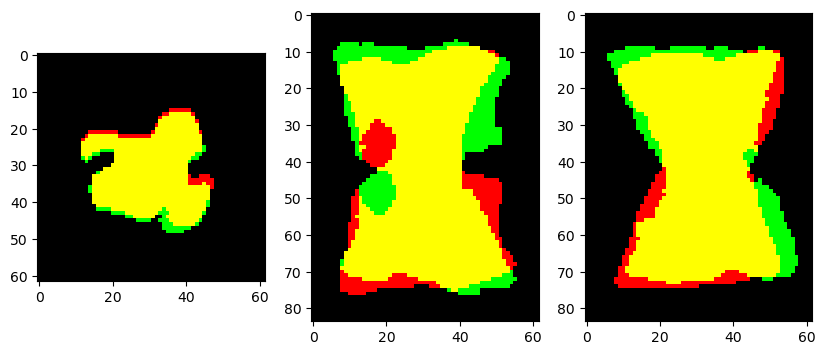

In [30]:
''' Display results in 2D'''
show_result_BFGS(Q, best_param)

In [38]:
''' Display results in 3D'''
show_result_BFGS(Q, best_param, V)

In [80]:
Q_bad = transform_3D(Q, angles = (0,100,25))
V.add_image(Q_bad, 
        colormap = 'Blues', 
        interpolation = 'nearest', 
        blending = 'translucent',
        rendering = 'iso'
        )

<Image layer 'Q_bad' at 0x260effe7ee0>

In [81]:
V.add_image(Q, 
        colormap = 'Oranges', 
        interpolation = 'nearest', 
        blending = 'translucent',
        rendering = 'iso'
        )

<Image layer 'Q [1]' at 0x260f00d9de0>

In [83]:
# Find indices of the data points

img = Q_bad
edges = sobel(img)
otsu = threshold_otsu(edges)
edges = edges > otsu
z, y, x = np.nonzero(edges)

# Center at center of mass
x_centered = x - x.mean()
y_centered = y - y.mean()
z_centered = z - z.mean()

ZYX = np.vstack((z_centered, y_centered, x_centered)).T

# Compute PCA to get axes of inertia
pca = decomposition.PCA(n_components = 3)
pca.fit(ZYX)
rot = pca.components_ # Retrieves the rotation matrix

slices, rows, cols = img.shape[0], img.shape[1], img.shape[2] 
center = np.array((slices, cols, rows)) / 2. - 0.5

tform1 = EuclideanTransform(translation = center, dimensionality=3)

# Rotation
tform2 = EuclideanTransform(rotation = (0, 0, 0), dimensionality=3)
tform2.params[:3, :3] = rot.T

# Back to original position
tform3 = EuclideanTransform(translation = -center, dimensionality=3)

# Perform the transforms
tform = tform3 + tform2 + tform1
Q_aligned = affine_transform(img, tform, order = 0, mode = 'constant')

V.add_image(Q_aligned, 
        colormap = 'RdPu', 
        interpolation = 'nearest', 
        blending = 'translucent',
        rendering = 'iso'
        )

<Image layer 'Q_aligned' at 0x260f00fec20>

In [94]:
t = [230, 50, 20]
max(t)

230

In [97]:
np.ceil(max(t)/150)

2.0